# Milestone 2: Data exploration 

For the purpose of the Milestone 2, this notebook aims to cover the data exploration needed to define our project.

In [1]:
# Library
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset 
from src.scripts.load_and_save import load_data

df_bindingDB = load_data()
df_bindingDB.head()


/mloscratch/homes/mdupont/other/ada/ada-2024-project-laambada/src/scripts/load_and_save.py:11: DtypeWarning: Columns (8,9,10,11,12,13,15,17,20,21,22,23,27,28,32,33,35,36,45,46,47,48,50,51,52,53,54,55,57,58,59,60,62,63,64,65,66,67,69,70,71,72,74,75,76,77,78,79,81,82,83,86,87,88,89,90,91,93,94,95,98,99,100,101,102,103,105,106,107,110,111,112,113,114,115,117,118,119,122,123,124,125,126,127,129,130,131,134,135,136,137,138,139,146,147,148,149,150,151,158,159,160,161,162,163,170,172,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, sep='\t', on_bad_lines='skip')


,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Recommended Name of Target Chain.12,UniProt (SwissProt) Entry Name of Target Chain.12,UniProt (SwissProt) Primary ID of Target Chain.12,UniProt (SwissProt) Secondary ID(s) of Target Chain.12,UniProt (SwissProt) Alternative ID(s) of Target Chain.12,UniProt (TrEMBL) Submitted Name of Target Chain.12,UniProt (TrEMBL) Entry Name of Target Chain.12,UniProt (TrEMBL) Primary ID of Target Chain.12,UniProt (TrEMBL) Secondary ID(s) of Target Chain.12,UniProt (TrEMBL) Alternative ID(s) of Target Chain.12
0,1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,InChI=1S/C31H42N2O7/c34-27(35)17-9-3-11-19-32-...,XGEGDSLAQZJGCW-HHGOQMMWSA-N,608734,"6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypent...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,InChI=1S/C31H34N6O3/c38-29-27(17-23-9-3-1-4-10...,UZLMEAPBHYEHAC-UNTBESQGSA-N,22,"(4R,5S,6S,7R)-4,7-dibenzyl-5,6-dihydroxy-1,3-b...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,InChI=1S/C29H34N4O3/c34-27-25(16-21-8-3-1-4-9-...,HYNYUFZPPJMPOB-UTWJFGBXSA-N,23,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,InChI=1S/C29H40N2O4/c32-18-10-2-1-9-17-30-25(1...,YXVAZXDWVZTGGD-VIJSPRBVSA-N,24,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,InChI=1S/C28H38N2O4/c31-17-9-3-8-16-29-24(18-2...,WWTSWTPNILRSJX-XDZXDJIYSA-N,25,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_bindingDB.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2913040 entries, 0 to 2913039
Data columns (total 194 columns):
 #    Column                                                                Non-Null Count    Dtype  
---   ------                                                                --------------    -----  
 0    BindingDB Reactant_set_id                                             2913040 non-null  int64  
 1    Ligand SMILES                                                         2913040 non-null  object 
 2    Ligand InChI                                                          2789344 non-null  object 
 3    Ligand InChI Key                                                      2789344 non-null  object 
 4    BindingDB MonomerID                                                   2913040 non-null  int64  
 5    BindingDB Ligand Name                                                 2913040 non-null  object 
 6    Target Name                                                     

## 1. First Glimps Of The Dataset

In [4]:
print(f'The dataset contains {df_bindingDB.shape[0]} samples and has {df_bindingDB.shape[1]} columns.')

The dataset contains 2913040 samples and has 194 columns.


We can split the colmuns in 3 categories depending on the information that they provide: 
- Ligand information and names and species of targets : columns from 0 to 8
- Reaction information : columns from 8 to 16
- Detailed targets information : columns from 16 to 194

In [5]:
# Data Exploration: Due to the huge size of the dataset we will drive our analysis on a subset
#df_subset = df_bindingDB.loc[100: 100040].copy()

In [6]:
# Util functions to explore the columns 
from src.utils.exploration_and_clean import explore_column, quick_check_column, clean_metrics

### 1.1 Ligand information

In [7]:
# This part concerne the columns form 0 to 
df_bindingDB.columns[0:8]

Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource'],
      dtype='object')

In [8]:
for i in range(8) :
    explore_column(df_bindingDB, i)
    print()

# BindingDB Reactant_set_id
0 nan values (0.0%)


2913039 unique values

# Ligand SMILES
0 nan values (0.0%)
1260604 unique values

# Ligand InChI
123696 nan values (4.25%)
1203990 unique values

# Ligand InChI Key
123696 nan values (4.25%)
1203990 unique values

# BindingDB MonomerID
0 nan values (0.0%)
1264593 unique values

# BindingDB Ligand Name
0 nan values (0.0%)
1277349 unique values

# Target Name
0 nan values (0.0%)
6716 unique values

# Target Source Organism According to Curator or DataSource
1020981 nan values (35.05%)
330 unique values



##### **Rdkit**
https://www.rdkit.org \
Rdkit is an open-source toolkit for cheminformatics. It allows to extract the chemical properties from the SMILES of the ligands, present in the binding DB dataset.\
Using it we will allow to extract the molecular weight, the composition, the hydrophobicity and the charge of the ligands. \
/!\ Don't forget to install it, if it's not already done!

In [9]:
# Ligan analysis 
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments

In [10]:
from rdkit.Chem import Draw
# Example molecule
sample_molecule = Chem.MolFromSmiles(df_bindingDB["Ligand SMILES"].iloc[0])
Draw.MolToImage(sample_molecule)

ImportError: libXext.so.6: cannot open shared object file: No such file or directory

In [12]:
# What informations can rdkit give ? 
sample_molecule = Chem.MolFromSmiles(df_bindingDB["Ligand SMILES"].iloc[0])

print("Molecular weight of the first molecule: ", Descriptors.MolWt(sample_molecule))
print("Number of valence electrons of the first molecule: ", Descriptors.NumValenceElectrons(sample_molecule))
Chem.Descriptors.CalcMolDescriptors(sample_molecule, missingVal=None, silent=True)

Molecular weight of the first molecule:  554.6840000000004
Number of valence electrons of the first molecule:  218


{'MaxAbsEStateIndex': 14.223190612664819,
 'MaxEStateIndex': 14.223190612664819,
 'MinAbsEStateIndex': 0.05986805291628916,
 'MinEStateIndex': -1.200094113938812,
 'qed': 0.2304717751982941,
 'SPS': 21.3,
 'MolWt': 554.6840000000004,
 'HeavyAtomMolWt': 512.3480000000004,
 'ExactMolWt': 554.299201684,
 'NumValenceElectrons': 218,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.32021031282041357,
 'MinPartialCharge': -0.4812303897601527,
 'MaxAbsPartialCharge': 0.4812303897601527,
 'MinAbsPartialCharge': 0.32021031282041357,
 'FpDensityMorgan1': 0.6,
 'FpDensityMorgan2': 0.975,
 'FpDensityMorgan3': 1.325,
 'BCUT2D_MWHI': 16.36899465541907,
 'BCUT2D_MWLOW': 9.906427515223882,
 'BCUT2D_CHGHI': 2.4540709426594813,
 'BCUT2D_CHGLO': -2.3549040388023554,
 'BCUT2D_LOGPHI': 2.28074981851266,
 'BCUT2D_LOGPLOW': -2.5116655865435766,
 'BCUT2D_MRHI': 5.758520704102498,
 'BCUT2D_MRLOW': -0.13770030578744752,
 'AvgIpc': 2.9976676185193307,
 'BalabanJ': 1.8893830336002044,
 'BertzCT': 982.36825246807

In [ ]:
# let's see if we can use it in a feasable time
# To save executions time
execution_times = []
sample_size = 40000

smiles_to_molecules = []
for smiles in df_bindingDB['Ligand SMILES'][:sample_size]:
    start_time = time.time()
    molecule = Chem.MolFromSmiles(smiles) 
    smiles_to_molecules.append(molecule)
    end_time = time.time()
    execution_times.append(end_time - start_time)

# statistics for time
mean_time = np.mean(execution_times)
std_time = np.std(execution_times)

print(f"Mean execution time: {mean_time} seconds")
print(f"Standard deviation: {std_time} seconds")
print(f"Estimation for the full dataset: {round(len(df_bindingDB)*mean_time/60)} minutes")

molecules_series = pd.Series(smiles_to_molecules)

print(f"Number of molecules not processed by rdkit: {(molecules_series).isna().sum()} out of {len(molecules_series)} ligands")

[21:21:07] non-ring atom 28 marked aromatic
[21:21:07] non-ring atom 28 marked aromatic
[21:21:07] Explicit valence for atom # 28 N, 4, is greater than permitted
[21:21:11] Explicit valence for atom # 12 N, 4, is greater than permitted
[21:21:11] Explicit valence for atom # 12 N, 4, is greater than permitted


Mean execution time: 0.00021398782730102538 seconds
Standard deviation: 0.0007996547361881584 seconds
Estimation for the full dataset: 10 minutes
Number of molecules not processed by rdkit: 5 out of 40000 ligands


**Conclusion** \
Rdkit allow us to have more useful chemical information about the ligands. Most of ligands seem to be compatible with the tool. As it is time consuming, we will further filter the dataset before using it.

### 1.2 Reaction information 

In [38]:
# The affinity measurement are not to heavy to handle let's do the analysis over the all dataset. We make a copy to not modify informations before finshing the analysis
reaction_metrics = df_bindingDB.iloc[:, 8:16].copy()

In [22]:
for i in range(reaction_metrics.shape[1]) :
    explore_column(reaction_metrics, i)
    print()

# Ki (nM)
2321136 nan values (79.68%)
27546 unique values

# IC50 (nM)
967589 nan values (33.22%)
59209 unique values

# Kd (nM)
2802216 nan values (96.2%)
8074 unique values

# EC50 (nM)
2645258 nan values (90.81%)
23237 unique values

# kon (M-1-s-1)
2912034 nan values (99.97%)
662 unique values

# koff (s-1)
2912054 nan values (99.97%)
578 unique values

# pH
2697779 nan values (92.61%)
88 unique values

# Temp (C)
2712135 nan values (93.1%)
59 unique values



In [ ]:
# Among the metrics some of them are string, float. We clean them 
for col in reaction_metrics.columns[:-2] :
    reaction_metrics[col] = clean_metrics(reaction_metrics[col])
    # Check if its only float: 
    for metric in reaction_metrics[col].unique():
        if type(metric) != np.float64 :
            print(col, type(metric))


In [ ]:
# If we remove all the nan value at this step we will not have any metrics left 
print('Sample size with no nan value :', reaction_metrics.dropna().shape[0])

# But let's see how much data we have for each 
print('Individually we have : ')
for col in reaction_metrics.columns :
    col_no_nan = reaction_metrics[col].dropna()
    print(col, col_no_nan.shape[0])

Sample size with no nan value : 0
Individually we have : 
Ki (nM) 506521
IC50 (nM) 1540239
Kd (nM) 54450
EC50 (nM) 195226
kon (M-1-s-1) 83
koff (s-1) 46
pH 215261
Temp (C) 200905


Number of sample with pH information 215261


Text(0.5, 1.0, 'pH distribution in logscale')

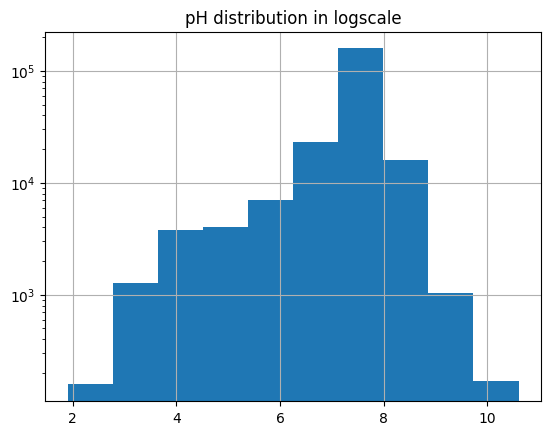

In [25]:
# let's check the pH information
nb = reaction_metrics['pH'].dropna().shape[0]
print('Number of sample with pH information', nb)

reaction_metrics['pH'].dropna().hist(log=True)
plt.title('pH distribution in logscale')

Number of sample with temperature information 200905


Text(0.5, 1.0, 'Temperature distribution in logscale')

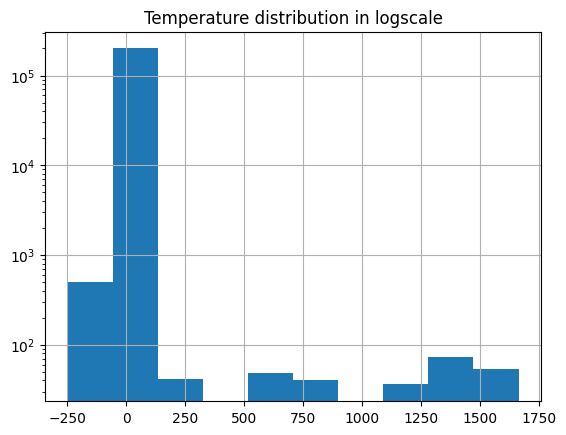

In [26]:
# let's check the temperature information
nb = reaction_metrics['Temp (C)'].dropna().shape[0]
print('Number of sample with temperature information', nb)

# Need to be clean (remove C and to float)
reaction_metrics['Temp (C)'] = clean_metrics(reaction_metrics['Temp (C)'])

reaction_metrics['Temp (C)'].dropna().hist(log=True)
plt.title('Temperature distribution in logscale')

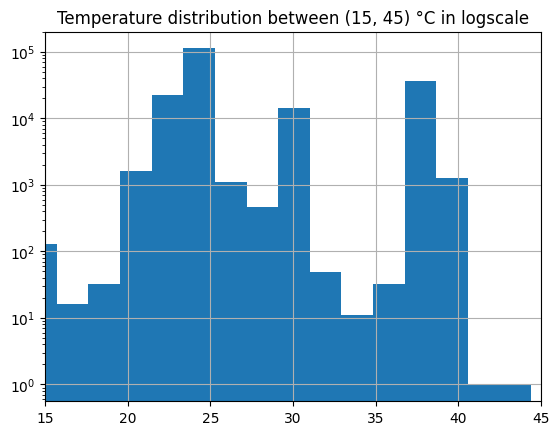

In [28]:
# Closer look to the physiolocial level
reaction_metrics['Temp (C)'].dropna().hist(log=True, bins=1000)
plt.xlim(15,45)
plt.title('Temperature distribution between (15, 45) °C in logscale')
plt.show()

*Remarks:*

For pH and Temperature, the human physiological values are Temp ~ 37 °C and pH =7, while in vitro experiments Temp ~25 °C. It would be interesting to affine our analysis, but we have not enough data to incorporate this in our analysis.

### 1.3 Target information

In [29]:
# Column list 
df_bindingDB[16:len(df_bindingDB.columns)].columns 

Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource', 'Ki (nM)',
       'IC50 (nM)',
       ...
       'UniProt (SwissProt) Recommended Name of Target Chain.12',
       'UniProt (SwissProt) Entry Name of Target Chain.12',
       'UniProt (SwissProt) Primary ID of Target Chain.12',
       'UniProt (SwissProt) Secondary ID(s) of Target Chain.12',
       'UniProt (SwissProt) Alternative ID(s) of Target Chain.12',
       'UniProt (TrEMBL) Submitted Name of Target Chain.12',
       'UniProt (TrEMBL) Entry Name of Target Chain.12',
       'UniProt (TrEMBL) Primary ID of Target Chain.12',
       'UniProt (TrEMBL) Secondary ID(s) of Target Chain.12',
       'UniProt (TrEMBL) Alternative ID(s) of Target Chain.12'],
      dtype='object', length=194)

In [30]:
# Print the description for all 
for i in range(16, len(df_bindingDB.columns)) :
    explore_column(df_bindingDB, i)
    print()

# Curation/DataSource
0 nan values (0.0%)
9 unique values
['Curated from the literature by BindingDB' 'US Patent' 'PubChem'
 'PDSP Ki' 'Taylor Research Group, UCSD' 'CSAR' 'D3R' 'WIPO' 'ChEMBL']

# Article DOI
1359630 nan values (46.67%)
40728 unique values

# BindingDB Entry DOI
6121 nan values (0.21%)
51827 unique values

# PMID
1297514 nan values (44.54%)
41732 unique values

# PubChem AID
1755915 nan values (60.28%)
12911 unique values

# Patent Number
1774810 nan values (60.93%)
7335 unique values

# Authors
42804 nan values (1.47%)
47335 unique values

# Institution
42804 nan values (1.47%)
8510 unique values

# Link to Ligand in BindingDB
0 nan values (0.0%)
1264593 unique values

# Link to Target in BindingDB
0 nan values (0.0%)
9730 unique values

# Link to Ligand-Target Pair in BindingDB
0 nan values (0.0%)
2122813 unique values

# Ligand HET ID in PDB
2742075 nan values (94.13%)
14377 unique values

# PDB ID(s) for Ligand-Target Complex
2760623 nan values (94.77%)
13781 uniq

# Number of Protein Chains in Target (>1 implies a multichain complex)
0 nan values (0.0%)
12 unique values
[ 1  2  3  4  5  9 11  8  6 12  7 10]


<Axes: title={'center': 'Number of Protein Chains in Target'}, ylabel='Frequency'>

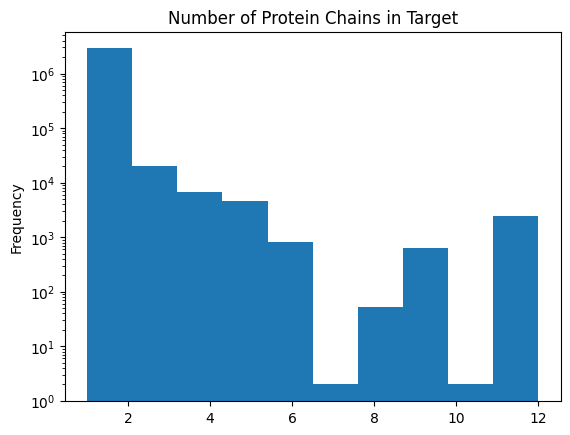

In [32]:
# Closer look into the multi chain values
i = 37
explore_column(df_bindingDB, i)

column = df_bindingDB[df_bindingDB.columns[i]]
column.plot(kind='hist', logy=True, title="Number of Protein Chains in Target")

<Axes: >

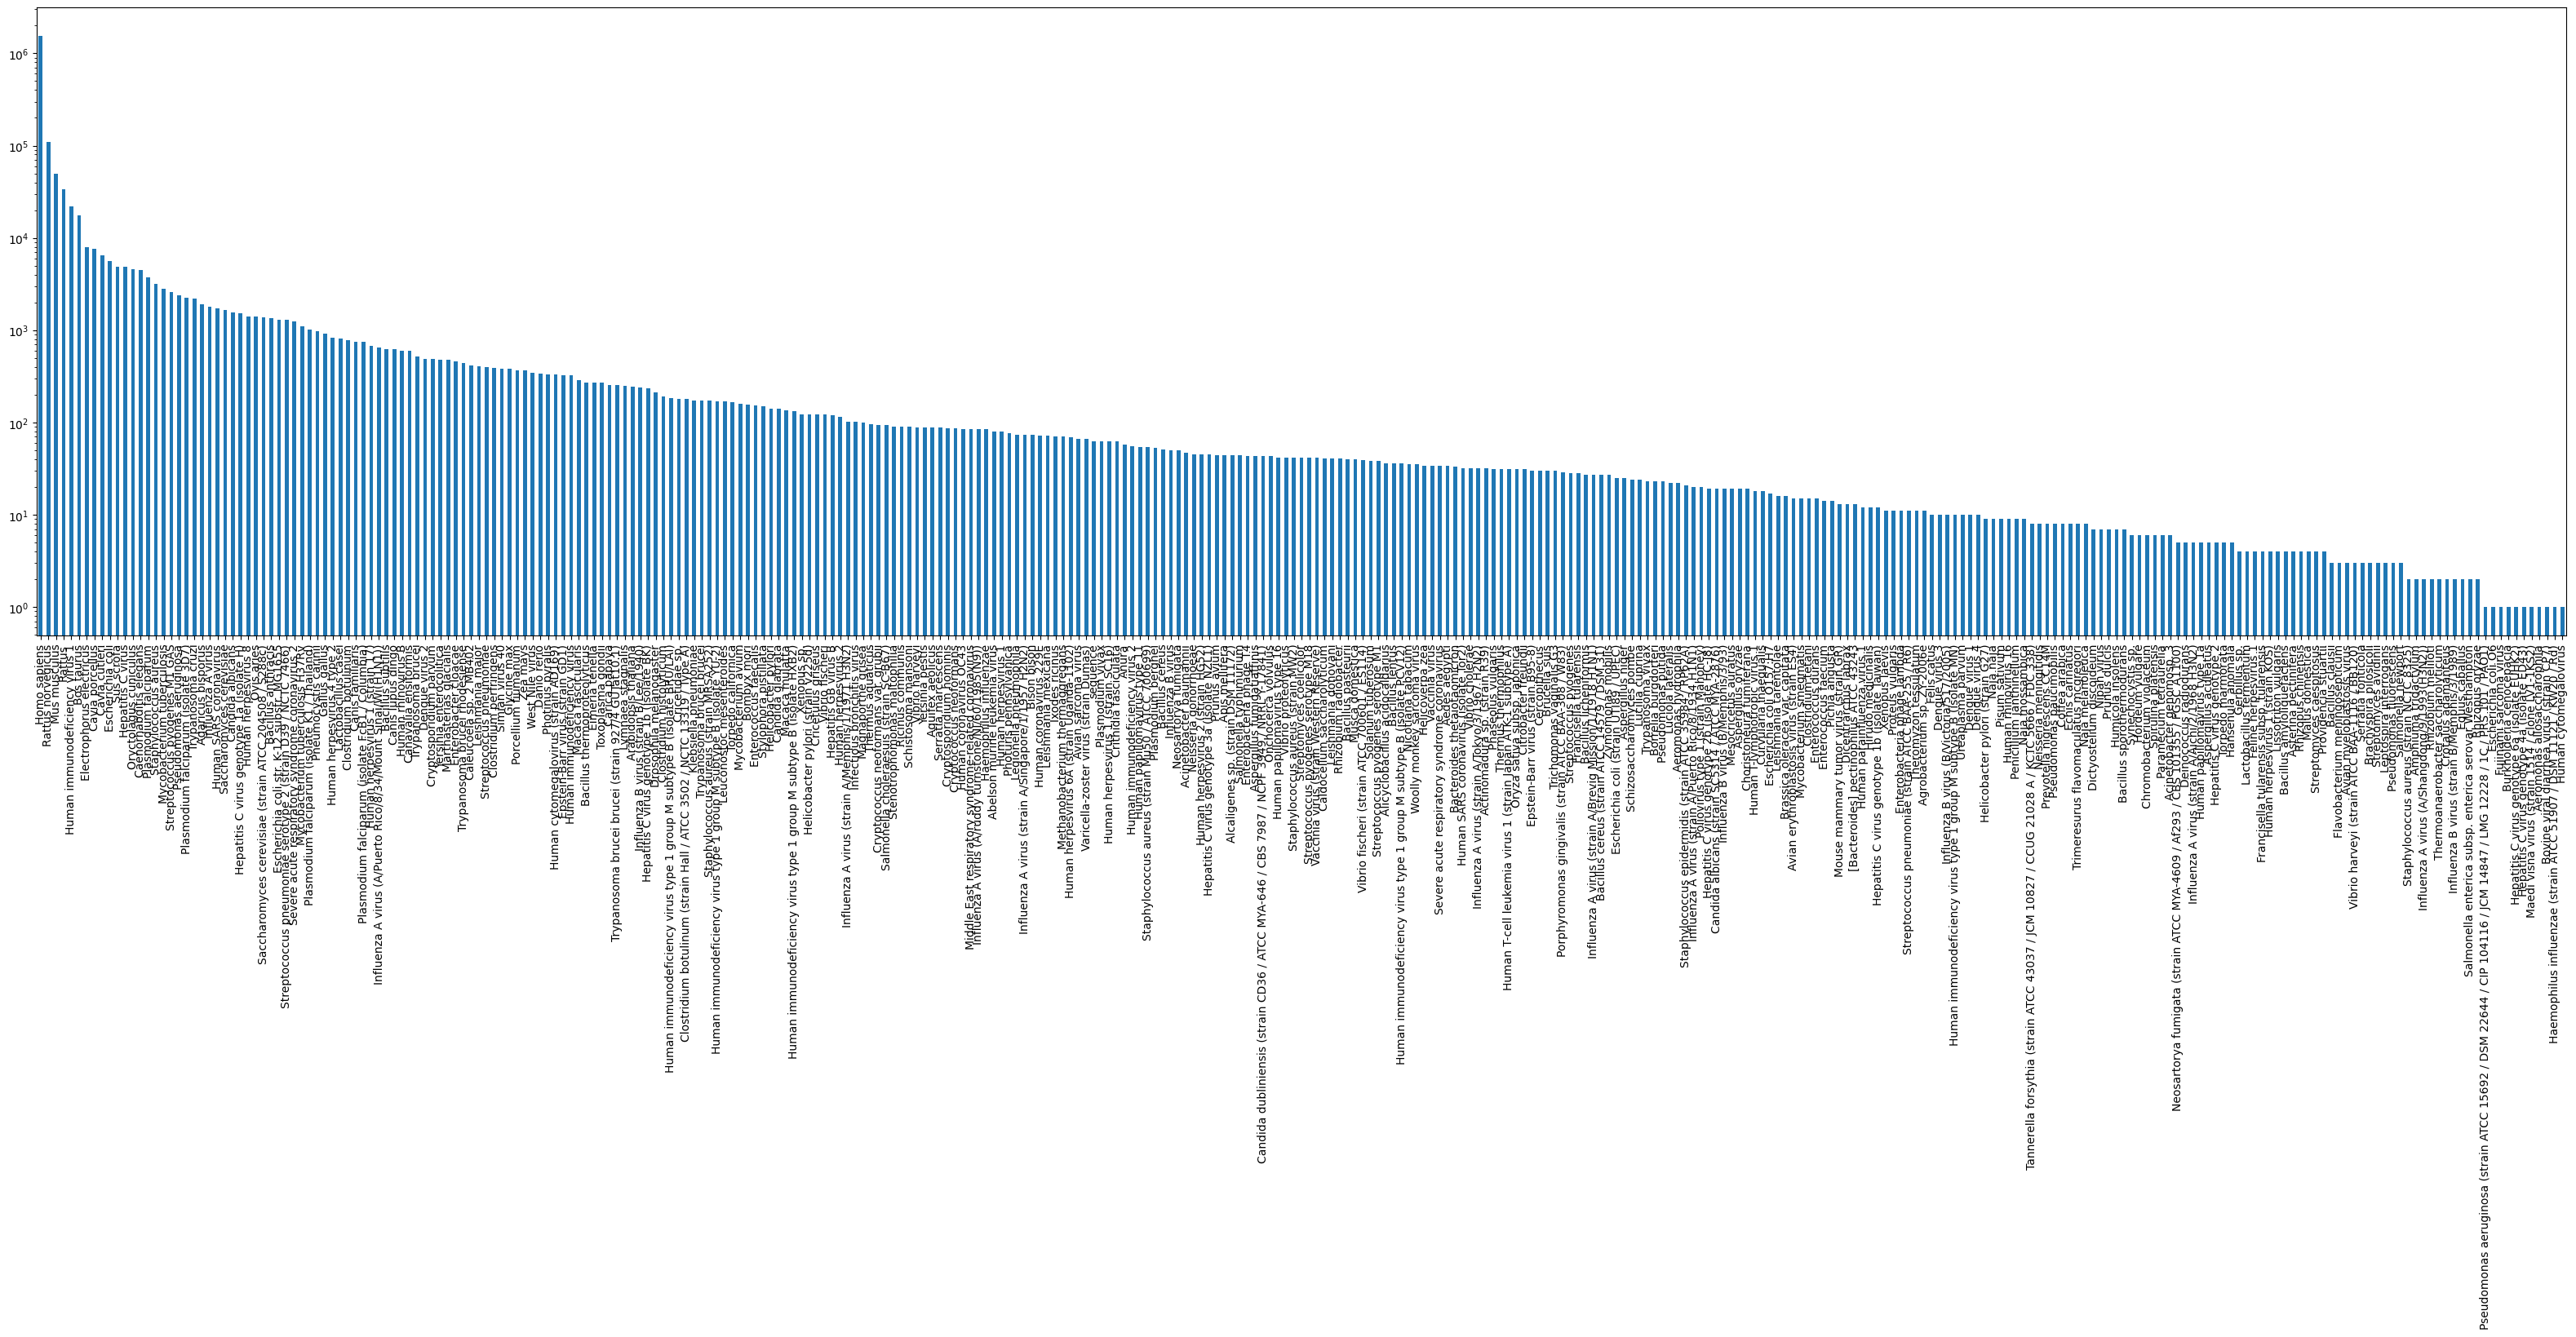

In [33]:
# Host organism 
fig, ax = plt.subplots(figsize=(10, 5))
df_bindingDB["Target Source Organism According to Curator or DataSource"].value_counts().plot(kind="bar", logy=True, figsize=(40, 10))

## 2. Data cleaning

### 1. Metric selection

In [34]:
# We don't have all the metrics for 1 sample but we do have sample with multiple metrics
commun_pairs= pd.DataFrame(index = reaction_metrics.columns, columns=reaction_metrics.columns)

from itertools import combinations

for i, j in combinations(reaction_metrics.columns, 2) : 
    commun_pairs.at[i, j]= reaction_metrics[[i, j]].dropna().shape[0]


# Put on the diagonal the number of sample for 1 metric
for col in reaction_metrics.columns :
    commun_pairs.at[col, col] = reaction_metrics[col].dropna().shape[0]

commun_pairs

,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),pH,Temp (C)
Ki (nM),506521,2857,13,787,0,1,34971,30354
IC50 (nM),NaN,1540239,110,1218,0,0,142514,129527
Kd (nM),NaN,NaN,54450,11,0,0,2019,1189
EC50 (nM),NaN,NaN,NaN,195226,0,0,6423,11667
kon (M-1-s-1),NaN,NaN,NaN,NaN,83,0,0,0
koff (s-1),NaN,NaN,NaN,NaN,NaN,46,11,8
pH,NaN,NaN,NaN,NaN,NaN,NaN,215261,129990
Temp (C),NaN,NaN,NaN,NaN,NaN,NaN,NaN,200905


In [35]:
# Let's try the trio 
trio = pd.DataFrame()

for i, j, k in combinations(reaction_metrics.columns, 3) : 
    nb = reaction_metrics[[i, j, k]].dropna().shape[0]
    
    if nb != 0 : 
        df = pd.DataFrame([[i, j, k, nb]])
        
        trio = pd.concat([trio, df])
        
trio.columns = [1, 2, 3, 'number']
trio

,1,2,3,number
0,Ki (nM),IC50 (nM),Kd (nM),8
0,Ki (nM),IC50 (nM),EC50 (nM),71
0,Ki (nM),IC50 (nM),pH,1443
0,Ki (nM),IC50 (nM),Temp (C),1399
0,Ki (nM),Kd (nM),pH,8
0,Ki (nM),Kd (nM),Temp (C),8
0,Ki (nM),EC50 (nM),pH,462
0,Ki (nM),EC50 (nM),Temp (C),397
0,Ki (nM),pH,Temp (C),22004
0,IC50 (nM),Kd (nM),pH,66


**Conclusion** \
Juste by looking at the number of data, we can say that an interesting choice could be either IC50 (1540239 samples) or Ki (506521 samples). Additionnaly both have information about temperature and pH : Ki : 22004 samples, IC50 84647 which can allow us to push further the analysis. \

Lets give some chemical theory to see what does this metrics give us about the reaction caracterization. \

*IC50*
- Half maximal inhibitory concentration,  effectiveness of a substance in inhibiting. 
- Concentration of a ligand that is required to inhibit 50% of a target's activity in a particular assay.
- Quantitative measure of how effective an inhibitor is.

*Ki*
- Inhibition constant, concentration of an inhibitor needed to decrease the enzyme's activity to half of its maximum rate when substrate concentration is high.
- Measures the binding affinity between the enzyme and the inhibitor (lower Ki values indicate stronger inhibition)
- Used in Michaelis-Menten kinetics to understand competitive, non-competitive, and uncompetitive inhibition.


*Relationship IC50 - Ki* : IC50 used in practical applications to assess inhibitor strength, depends on the concentrations. Ki is more specific to the interaction between the enzyme and the inhibitor. 


We will use the Ki that seems more suited to study the overall structrual properties associated to ligand-target binding.

In [36]:
# We choose Ki, let's select the samples in the full dataset

# put the clean Ki in the full dataset
df_bindingDB['Ki (nM)'] = reaction_metrics['Ki (nM)']

# take only the non nan value
df_bindingDB = df_bindingDB.dropna(subset=['Ki (nM)']) 

In [39]:
df_bindingDB.shape

(506521, 194)

### 2. Let's look for a suitable protein family to study
**Step 1. Match targets to their families. We made a choice to use PANTHER classification, although other classifications exist too.**

In [40]:
import sys
sys.path.append('./src/utils')
from retrieve_family import retrieve_family

uniprot_ids = df_bindingDB["UniProt (SwissProt) Entry Name of Target Chain"].unique()
family_dict = await retrieve_family(uniprot_ids)

# Set of unique protein families
families = set()
for key in family_dict:
    families.update(family_dict[key])

# Dictionary with the protein families as keys and the UniProt names as values
family_dict_2 = {family: [] for family in families}
for key in family_dict:
    for family in family_dict[key]:
        if key not in family_dict_2[family]:
            family_dict_2[family].append(key)

print(f"We were able to retrieve {len(families)} unique protein families")

100%|██████████| 2765/2765 [00:16<00:00, 172.52it/s]

We were able to retrieve 3646 unique protein families


**Step 2. Now that each target is mapped to its families, let's select families with adequate number of targets.**

In [41]:
import collections

# Count the number of proteins in each family, don't count families with less than n proteins
n = 5
counter = collections.Counter({k: len(v) for k, v in family_dict_2.items() if len(v) >= n})
counter.most_common(10)

[('UNCHARACTERIZED', 157),
 ('ADRENERGIC RECEPTOR-RELATED G-PROTEIN COUPLED RECEPTOR', 108),
 ('G-PROTEIN COUPLED RECEPTOR', 79),
 ('5-HYDROXYTRYPTAMINE RECEPTOR', 76),
 ('-', 72),
 ('TYROSINE-PROTEIN KINASE RECEPTOR', 71),
 ('SERINE/THREONINE-PROTEIN KINASE', 69),
 ('RIBOSOMAL PROTEIN S6 KINASE', 63),
 ('NEUROTRANSMITTER GATED ION CHANNEL', 61),
 ('NUCLEAR HORMONE RECEPTOR', 61)]

Let's filter out some families.

In [42]:
# Drop if family is "-" or "UNCHARACTERIZED"
del counter["-"]
del counter["UNCHARACTERIZED"]
# Only keep families if they are in the counter
family_dict_2 = {k: v for k, v in family_dict_2.items() if k in counter.keys()}
# Only keep proteins if they are in family_dict_2
ids = set()
for key in family_dict_2:
    ids.update(family_dict_2[key])
family_dict = {k: v for k, v in family_dict.items() if k in ids}

In [57]:
df_bindingDB_filtered = df_bindingDB[df_bindingDB['UniProt (SwissProt) Entry Name of Target Chain'].isin(family_dict.keys())].copy()

**Step 3. We would need targets with enough ligands.**

Let's count ligands in each family.

In [58]:
summary_families = pd.DataFrame.from_dict(counter, orient='index', columns=['Number of targets'])
grouped = df_bindingDB_filtered.groupby('UniProt (SwissProt) Entry Name of Target Chain').count()["Ki (nM)"]
# Discard counts lower than threshold
# threshold = 1000
# grouped = grouped[grouped > threshold]
ligands_count = collections.Counter()
for target in family_dict.keys():
    for family in family_dict[target]:
        try:
            ligands_count[family] += grouped[target]
        except KeyError:
            pass
summary_families["Number of ligands"] = [ligands_count[family] for family in summary_families.index]


In [59]:
summary_families["Average ligands per target"] = summary_families["Number of ligands"] / summary_families["Number of targets"]
summary_families["Average ligands per target"] = summary_families["Average ligands per target"].round(2)
summary_families = summary_families.sort_values(by="Average ligands per target", ascending=False)

In [60]:
summary_families.head(15)

,Number of targets,Number of ligands,Average ligands per target
HISTAMINE RECEPTOR-RELATED G-PROTEIN COUPLED RECEPTOR,5,38502,7700.40
CB1 CANNABINOID RECEPTOR-INTERACTING PROTEIN 1,7,52604,7514.86
REGULATOR OF G PROTEIN SIGNALING,5,27478,5495.60
TYROSINE-PROTEIN KINASE HOPSCOTCH,9,30348,3372.00
"FAM11A, B PROTEIN",5,15969,3193.80
PERIPHERAL-TYPE BENZODIAZEPINE RECEPTOR,5,14317,2863.40
PALMITOYLTRANSFERASE ZDHHC16,6,16508,2751.33
PITUITARY HOMEOBOX HOMOLOG PTX1,6,16040,2673.33
CHLORIDE INTRACELLULAR CHANNEL PROTEIN 6-RELATED,13,33683,2591.00
INTERFERON/INTERLEUKIN RECEPTOR,7,17425,2489.29


**Step 4. Zoom on suitable candidates.**

Let's look at our winner, the `TYROSINE-PROTEIN KINASE HOPSCOTCH` family! At this stage, we used a combination of data balance considerations, personal preferences and biological knowledge to select a family with a manageable amount of targets and a considerable amount of ligands per target.

In [61]:
for target in family_dict_2["TYROSINE-PROTEIN KINASE HOPSCOTCH"]:
    if target in grouped:
        print(f"{target} has {grouped[target]} ligands")

PDE4A_HUMAN has 94 ligands
MERTK_HUMAN has 10 ligands
CCR5_HUMAN has 207 ligands
TEC_HUMAN has 2 ligands
CCR5_MOUSE has 51 ligands
TYK2_HUMAN has 1899 ligands
JAK3_HUMAN has 1797 ligands
JAK2_HUMAN has 3698 ligands
JAK1_HUMAN has 3817 ligands


### 3. Ligand selection
After selecting the desired subset of data, we will use Rdkit to extract the chemical properties of the ligands.

In [62]:
# We only keep the ligand that are rdkit compatible 
execution_times = []

smiles_to_molecules = []
for smiles in df_bindingDB_filtered['Ligand SMILES']:
    start_time = time.time()
    molecule = Chem.MolFromSmiles(smiles) 
    smiles_to_molecules.append(molecule)
    end_time = time.time()
    execution_times.append(end_time - start_time)

mean_time = np.mean(execution_times)
std_time = np.std(execution_times)

print(f"Mean execution time: {mean_time} seconds")
print(f"Standard deviation: {std_time} seconds")

df_bindingDB_filtered['RDKIT Molecules'] = smiles_to_molecules

[21:43:20] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 15 16
[21:43:20] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16
[21:43:20] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 15 16
[21:43:20] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[21:43:21] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[21:43:21] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[21:43:21] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[21:43:21] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[21:43:21] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[21:43:21] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[21:43:21] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
[21:43:21] Explicit valence for atom # 0 N, 4, is greater than permitted
[21:43:21] Explicit valence for atom # 0 N, 4, is greater than permitted
[21:43:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 17 18 19 30 31 32
[21:43:22] Can't kekulize mol.  Unkekuliz

Mean execution time: 0.00023273319723949115 seconds
Standard deviation: 0.0005593001946770456 seconds


In [63]:
df_bindingDB_filtered['RDKIT Molecules'].isna().sum()
print(f"Number of molecules not processed by rdkit: {df_bindingDB_filtered['RDKIT Molecules'].isna().sum()} out of {len(df_bindingDB_filtered)} ligands")

# Cleaning
df_bindingDB_filtered.dropna(subset=['RDKIT Molecules'], inplace=True)

Number of molecules not processed by rdkit: 345 out of 489218 ligands


## 3. Chemical characterization


### 1. Characterization of all the ligands of the family

#### 1.1 Univariate visual anaylsis
Let's use Rdkit to extract the chemical properties of the ligands. We will look at chemical properties that are relevant for drug discovery, as follows:
* Molecular weight
* Functionnal composition count
* Hydrophobicity
* Charge

Mean execution time: 0.00011863402417545808 seconds
Standard deviation: 0.0004116977840818154 seconds


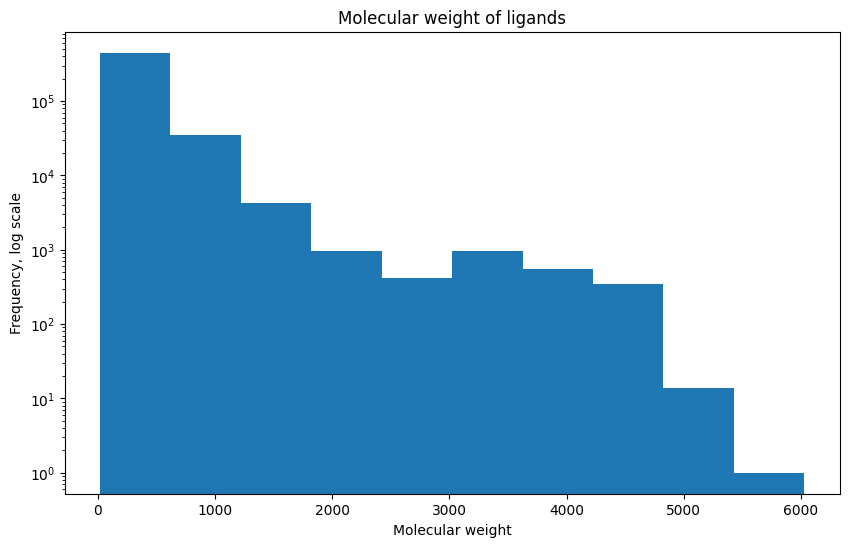

In [64]:
# 1. Molecular weight
molecular_weights = []

for molecule in df_bindingDB_filtered['RDKIT Molecules']:
    start_time = time.time()
    mw = Descriptors.MolWt(molecule)   
    molecular_weights.append(mw) 
    end_time = time.time()
    execution_times.append(end_time - start_time)

df_bindingDB_filtered['Ligand MW'] = molecular_weights

mean_time = np.mean(execution_times)
std_time = np.std(execution_times)

print(f"Mean execution time: {mean_time} seconds")
print(f"Standard deviation: {std_time} seconds")

# Plot
plt.figure(figsize=(10, 6))
df_bindingDB_filtered['Ligand MW'].plot(kind = 'hist', logy=True)
plt.xlabel('Molecular weight')
plt.ylabel('Frequency, log scale')
plt.title('Molecular weight of ligands')
plt.show()

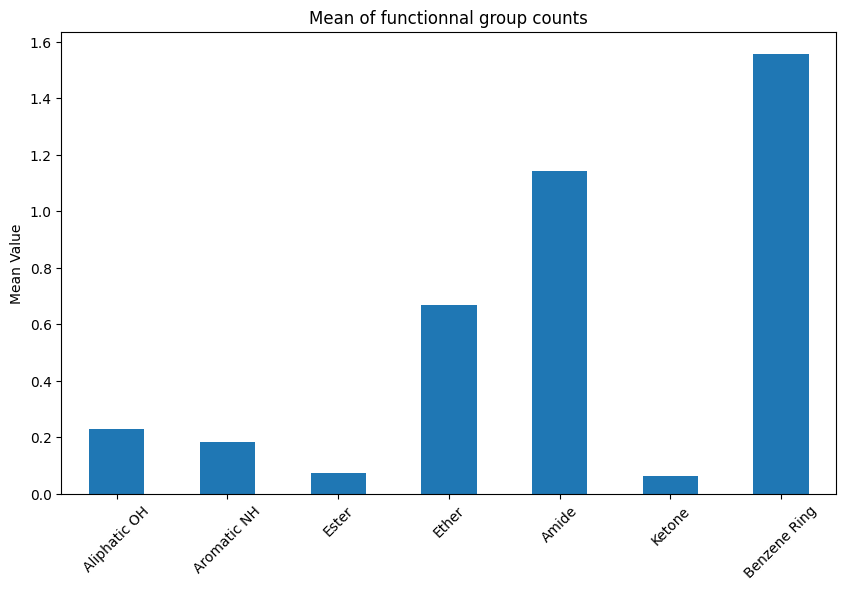

In [65]:
# 2. Functionnal group counts 

# Extract SMILES 
smiles_list = df_bindingDB_filtered['Ligand SMILES']  

# Calculate functional group counts for each molecule
results = []
for smiles in smiles_list:
    molecule = Chem.MolFromSmiles(smiles)
    if molecule:
        counts = {
            "SMILES": smiles,
            "Aliphatic OH": Fragments.fr_Al_OH(molecule),
            "Aromatic NH": Fragments.fr_Ar_NH(molecule),
            "Ester": Fragments.fr_ester(molecule),
            "Ether": Fragments.fr_ether(molecule),
            "Amide": Fragments.fr_amide(molecule),
            "Ketone": Fragments.fr_ketone(molecule),
            "Benzene Ring": Fragments.fr_benzene(molecule),
        }
        results.append(counts)

# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_results.set_index('SMILES', inplace=True)
df_results.head()

# Plot 
column_means = df_results.mean()

plt.figure(figsize=(10, 6))
column_means.plot(kind='bar')
plt.ylabel('Mean Value')
plt.title('Mean of functionnal group counts')
plt.xticks(rotation=45)
plt.show()

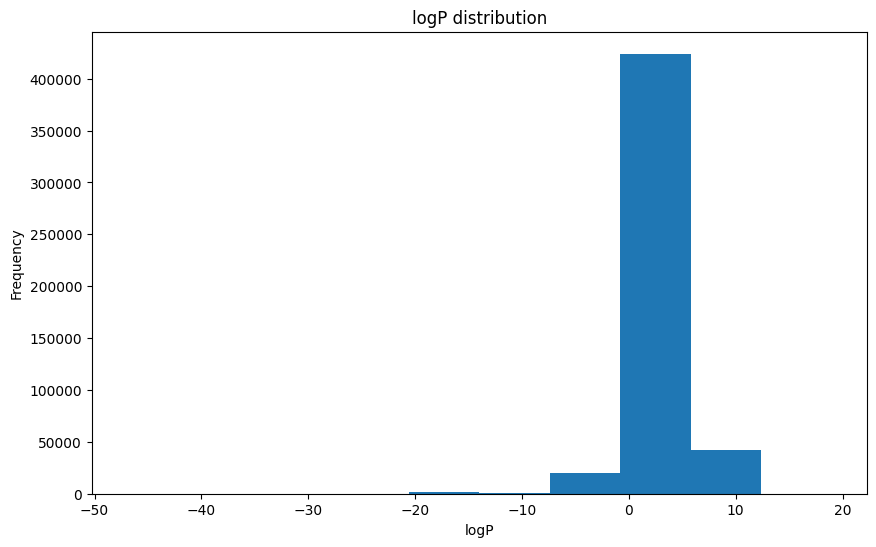

In [ ]:
# 3. Hydrophobicity
df_bindingDB_filtered['logP'] = [Descriptors.MolLogP(molecule) for molecule in df_bindingDB_filtered['RDKIT Molecules']]

plt.figure(figsize=(10, 6))
df_bindingDB_filtered['logP'].plot(kind='hist')
plt.xlabel('logP')
plt.ylabel('Frequency')
plt.title('logP distribution')
plt.show()

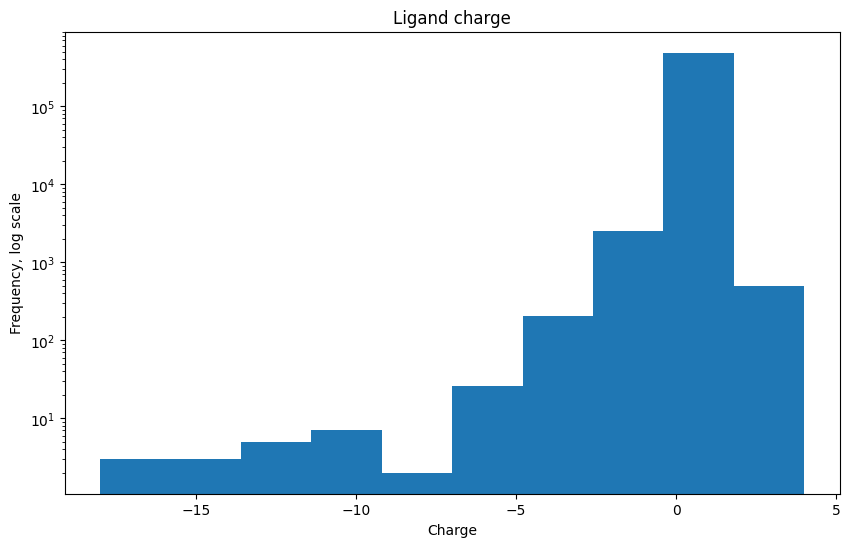

In [67]:
# 4. Charge
df_bindingDB_filtered['Charge'] = [Chem.GetFormalCharge(molecule) for molecule in df_bindingDB_filtered['RDKIT Molecules']]

plt.figure(figsize=(10, 6))
df_bindingDB_filtered['Charge'].plot(kind='hist', logy=True)
plt.xlabel('Charge')
plt.ylabel('Frequency, log scale')
plt.title('Ligand charge')
plt.show()

#### 1.2 Analysis with respect to the target

We will look at the distribution of the chemical properties of the ligands with respect to the target. 

In [68]:
unique_targets, counts = np.unique(df_bindingDB_filtered['Target Name'], return_counts=True)

# Créer un DataFrame à partir des données uniques et de leurs comptes
df_targets = pd.DataFrame({
    'Target Name': unique_targets,
    'Count': counts
})

/tmp/ipykernel_9427/2017848250.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  max_x2 = df_bindingDB_filtered.groupby(['Target Name']).mean()['Ligand MW'].max()
/tmp/ipykernel_9427/2017848250.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bindingDB_filtered.groupby(['Target Name']).mean()['Ligand MW'].plot(kind='hist', bins=bins, ax=axes[1])


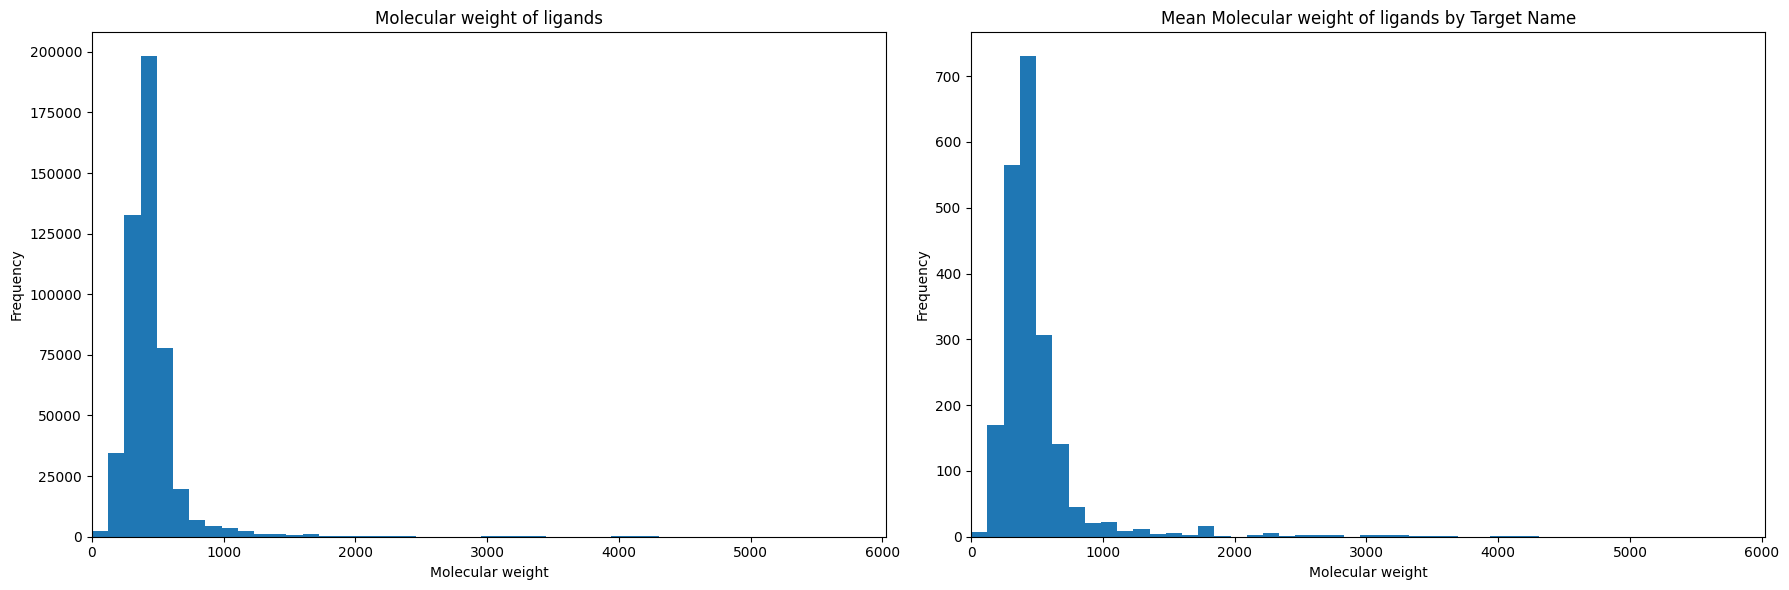

In [70]:
# Calculer les limites de l'axe x
max_x1 = df_bindingDB_filtered['Ligand MW'].max()
max_x2 = df_bindingDB_filtered.groupby(['Target Name']).mean()['Ligand MW'].max()
max_x = max(max_x1, max_x2)

bins = np.linspace(0, max_x, 50)

# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Premier graphique : histogramme du poids moléculaire des ligands
df_bindingDB_filtered['Ligand MW'].plot(kind='hist', bins=bins, ax=axes[0])
axes[0].set_xlabel('Molecular weight')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Molecular weight of ligands')
axes[0].set_xlim(0, max_x)

# Deuxième graphique : histogramme de la moyenne du poids moléculaire des ligands par nom de cible
df_bindingDB_filtered.groupby(['Target Name']).mean()['Ligand MW'].plot(kind='hist', bins=bins, ax=axes[1])
axes[1].set_xlabel('Molecular weight')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Mean Molecular weight of ligands by Target Name')
axes[1].set_xlim(0, max_x)

# Ajuster la disposition des sous-graphiques
plt.tight_layout()
plt.show()

#### 1.3 Multivariate analysis
After characterizing the ligands, we will look at the correlation between the chemical properties of the ligands and the value of interest, Ki.

## 4. Characterization via embeddings

### 1. Characterization of all the ligands of the family

### 2. Characterization of the ligands of a defined target

## 5. ML inference and comparison